### Import all the needed libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
sns.set_style('dark')

# Gene Expression Dataset

In [60]:
df1 = pd.read_csv('gene_expression.csv')
df1.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


#### We figure out that data is perfectly distributed and is not skewed

In [61]:
df1['Cancer Present'].value_counts()

1    1500
0    1500
Name: Cancer Present, dtype: int64

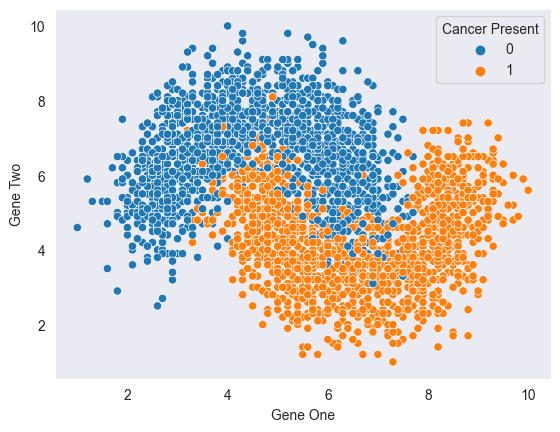

In [62]:
sns.scatterplot(data=df1, x='Gene One', y='Gene Two', hue='Cancer Present')
plt.show()

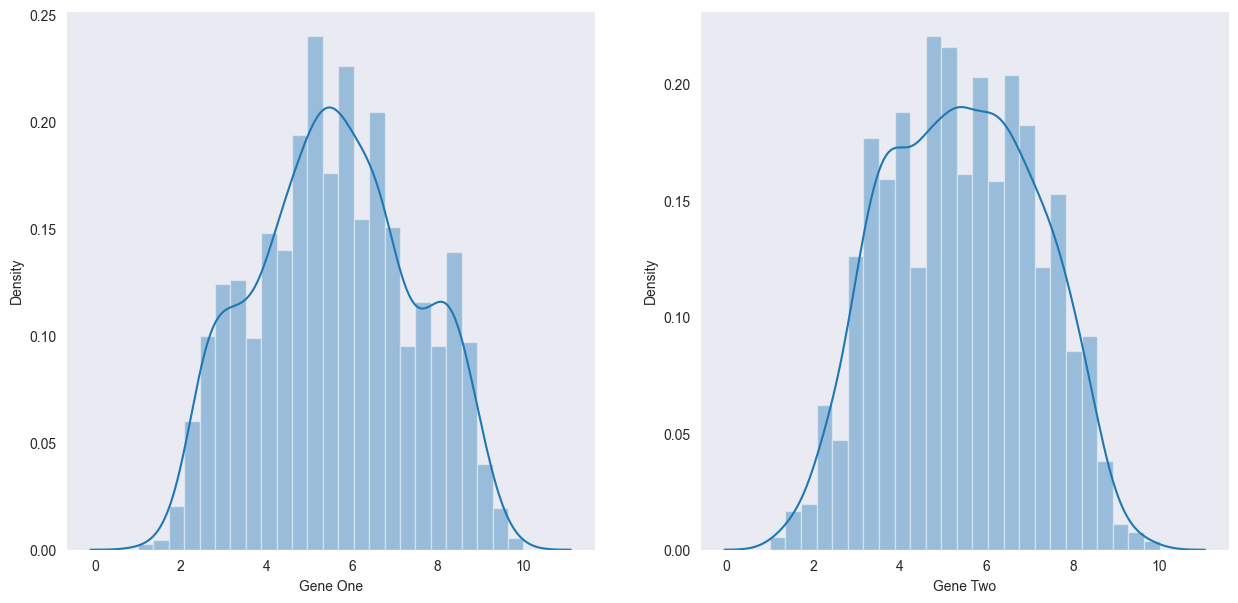

In [63]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
sns.distplot(df1['Gene One'], ax=ax[0])
sns.distplot(df1['Gene Two'], ax=ax[1])
plt.show()

In [83]:
y = df1['Cancer Present']
X = df1.drop('Cancer Present', axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Logistic Regression

In [84]:
logistic_test_error = []
logistic_train_error = []
for i in range(1, 20):
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)

    logistic = LogisticRegression()
    logistic.fit(X_train_scaled, y_train)
    logistic_test_predictions = logistic.predict(X_test_scaled)
    logistic_train_predictions = logistic.predict(X_train_scaled)

    logistic_test_error.append(1 - accuracy_score(y_test, logistic_test_predictions))
    logistic_train_error.append(1 - accuracy_score(y_train, logistic_train_predictions))
    

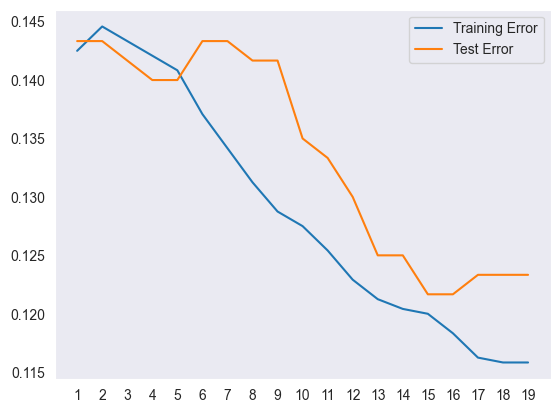

In [85]:
sns.lineplot(np.arange(1, 20), logistic_train_error, label="Training Error")
sns.lineplot(np.arange(1, 20), logistic_test_error, label='Test Error')
plt.xticks(np.arange(1, 20))
plt.show()

#### We choose degree=15 as it has the lowest test error to avoid overfitting

In [92]:
poly = PolynomialFeatures(degree=15)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

logistic = LogisticRegression()
logistic.fit(X_train_scaled, y_train)
logistic_predictions = logistic.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logistic_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, logistic_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logistic_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, logistic_predictions)))

Accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1-score: 0.88


# KNN

#### We compare KNN models with k=1:40 considering only the odd values since odd values are recommended to avoid ties

In [101]:
potential_k = np.arange(1, 40, 2)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
knn_test_error = []
for k in potential_k:
    knn = KNN(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_predictions = knn.predict(X_test_scaled)
    knn_test_error.append(1 - accuracy_score(y_test, knn_predictions))

## Using elbow method, K = 7 seems to be a good choice.

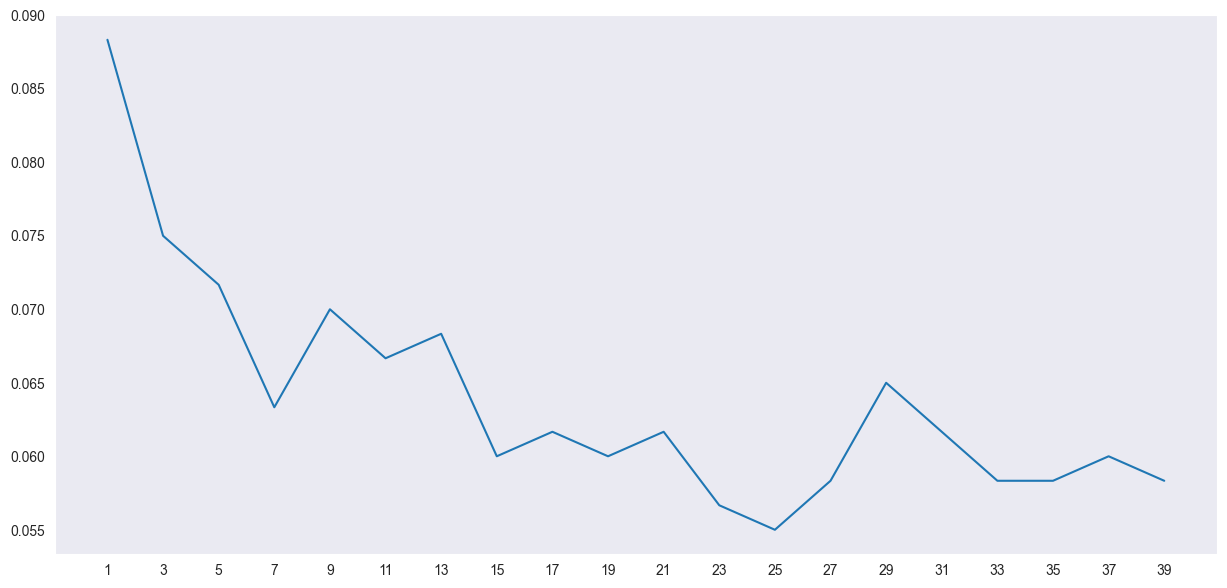

In [104]:
fig, _ = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
sns.lineplot(potential_k, knn_test_error)
plt.xticks(potential_k)
plt.show()

In [106]:
knn = KNN(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
knn_predictions = knn.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, knn_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, knn_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, knn_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, knn_predictions)))

Accuracy: 0.94
Precision: 0.93
Recall: 0.95
F1-score: 0.94


# SVM

#### We implemented a function that takes a kernel and compares training using different C values to use it whenever we need to train SVMs.

In [5]:
def train_svm(kernel, c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], degree=1):
    maxx = 0
    for C in c:
        svm = SVC(kernel=kernel, C=C, degree=degree)
        svm.fit(X_train_scaled, y_train)
        svm_predictions = svm.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, svm_predictions)
        if accuracy > maxx:
            maxx = accuracy
            model = svm
    return model

## Linear Kernel

In [145]:
svm_linear = train_svm('linear')
svm_linear_predictions = svm_linear.predict(X_test_scaled)
print('Best C: {}'.format(svm_linear.C))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_linear_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_linear_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_linear_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_linear_predictions)))

Best C: 100
Accuracy: 0.86
Precision: 0.87
Recall: 0.85
F1-score: 0.86


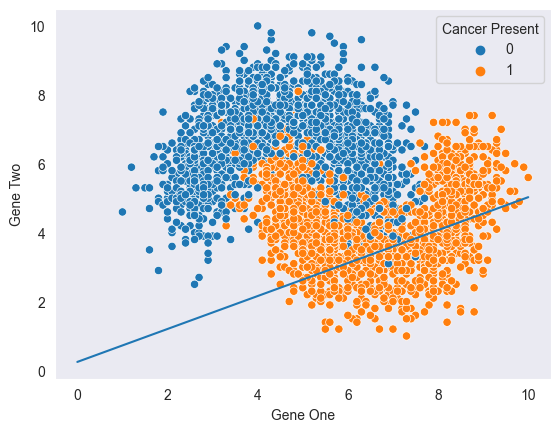

In [146]:
w1 = svm_linear.coef_[0, 0]
w2 = svm_linear.coef_[0, 1]
b = svm_linear.intercept_
x = np.arange(0, 11)
y = (- w1*x - b) / w2
sns.lineplot(x, y)
sns.scatterplot(data=df1, x='Gene One', y='Gene Two', hue='Cancer Present')
plt.show()

## RBF Kernel

In [147]:
svm_rbf = train_svm('rbf')
svm_rbf_predictions = svm_rbf.predict(X_test_scaled)
print('Best C: {}'.format(svm_rbf.C))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_rbf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_rbf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_rbf_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_rbf_predictions)))

Best C: 1
Accuracy: 0.94
Precision: 0.93
Recall: 0.95
F1-score: 0.94


## Poly Kernel

In [162]:
max_accuracy = 0
for i in range(2,4):
    svm_poly = train_svm(kernel='poly', c=[0.1, 1, 10, 100], degree=i)
    svm_poly_predictions = svm_poly.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, svm_poly_predictions)
    if max_accuracy < accuracy:
        max_accuracy = accuracy
        model = svm_poly
        degree = i

In [163]:
svm_poly_predictions = model.predict(X_test_scaled)
print('Degree : {}'.format(degree))
print('Best C: {}'.format(model.C))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_poly_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_poly_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_poly_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_poly_predictions)))

Degree : 2
Best C: 0.1
Accuracy: 0.85
Precision: 0.86
Recall: 0.86
F1-score: 0.86


# Conclusion
<ul>
<li>
    Since the dataset is not skewed, accuracy is a good mertic to use. However, since the model aim to detect cancer, we need to also consider the recall (true positive rate) as we need to detect the positive as positive. Hence we will compare the models based on accuracy and recall.
</li>
<li>KNN and SVM with RBF kernal had the best model accuracies and recall</li>
<li>KNN's good performance could be reasoned by the fact that the data does not have lots of featuers (just 2) and has no outliers. KNN, in general, works well in low-dimension input space but fails in high-dimension input space. In our case, we avoided the curse of dimensionality.
</li>
<li>SVM with RBF's good performance could be reasoned by the fact that the data is non-linear. This makes it more suitable than using the SVM linear kernel for example.</li>
<li>SVM with linear kernel and logistic Regression had relatively lower accuracies because the data is not linearly-separable.</li>
<li>SVM with polynomial kernel had nearly the same results as the SVM with linear kernel. This might be because the degree d needed to be higher in order to make the data more separable.</li>


</ul>

# Income Dataset

In [3]:
income_df = pd.read_csv('income/train.csv')
income_df.head()
df_test = income_df.copy()

## Handling Missing Values

### Since the number of missing values in column "native-country" is relatively low (less than 2%), we remove the rows which are missing values in this column

In [9]:
income_df['native-country'].isna().sum() / income_df.shape[0]


0.01735787246627386

In [ ]:
income_df = income_df[~income_df['native-country'].isna()]

### We fill missing values in column "workclass" with the mode value of this column

In [484]:
income_df['workclass'].fillna(income_df['workclass'].mode().values[0], inplace=True)

### Since a school or preschool student is expected to have the same salary regardless of the school grade he is in, we group all school pupils into one new category --> School. This will help in decreasing the dimensionality when doing one-hot encoding

In [485]:
mapp = dict.fromkeys(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th'], 'School')
mapp['Doctorate'] = 'Doctorate'
mapp['Bachelors'] = 'Bachelors'
mapp['Masters'] = 'Masters'
mapp['Some-college'] = 'Some-college'
mapp['Prof-school'] = 'Prof-school'
mapp['Assoc-acdm'] = 'Assoc-acdm'
mapp['Assoc-voc'] = 'Assoc-voc'
mapp['HS-grad'] = 'HS-grad'
income_df['education'] = income_df['education'].map(mapp)

In [12]:
income_df['occupation'].value_counts()

Craft-repair         5519
Prof-specialty       5518
Exec-managerial      5506
Adm-clerical         5004
Sales                4965
Other-service        4448
Machine-op-inspct    2711
Transport-moving     2121
Handlers-cleaners    1878
Farming-fishing      1348
Tech-support         1321
Protective-serv       874
Priv-house-serv       225
Armed-Forces           13
Name: occupation, dtype: int64

### Now, we found that the categories counts in the "occupation" column are very near to each other. In other words, there is no one category that can be considered as a mode which we can use to fill the missing values.
### That is why we thought that the best way to fill these values is based on the education degree. For example, a peerson with a "Doctorate" education will be given (based on mode) an occupation in "prof-specialty"

In [13]:
occupation_mode = {}
education_list = income_df['education'].unique().tolist()
for education in education_list:
    occupation_mode[education] = income_df[income_df['education'] == education]['occupation'].mode().values[0]

In [14]:
occupation_mode["Doctorate"]

'Prof-specialty'

In [487]:
for education in occupation_mode:
    education_filter = (income_df['education'] == education) & (income_df['occupation'].isna())
    income_df.loc[education_filter, 'occupation'] = occupation_mode[education]

## Data Transformation & Feature Engineering

In [488]:
income_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,School,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,School,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [489]:
income_df['education'].unique()

array(['Doctorate', 'School', 'Bachelors', 'Some-college', 'HS-grad',
       'Masters', 'Prof-school', 'Assoc-voc', 'Assoc-acdm'], dtype=object)

### We convert the column "education" into number labels. Since they are ordered, it is ok to give them number labels.

In [490]:
mapp = {'School': 1, 'HS-grad': 2, 'Some-college': 3, 'Assoc-voc': 4, 'Assoc-acdm': 5, 
'Bachelors': 6, 'Masters': 7, 'Prof-school': 8, 'Doctorate': 9}
income_df['education'] = income_df['education'].map(mapp)
income_df.drop('educational-num', axis='columns', inplace=True)

### For simplicity, we convert the marital status to married (value=1) and not married (value=0). 

In [496]:
mapp = {'Divorced': 0, 'Never-married': 0, 'Widowed': 0, 'Separated': 0, 
'Married-spouse-absent': 1, 'Married-AF-spouse': 1, 'Married-civ-spouse': 1}
income_df['marital-status'] = income_df['marital-status'].map(mapp)
income_df.rename(columns={'marital-status': 'married'}, inplace=True)

### We find that native-country column has most values as United States. For simplicity and to avoid dimensionality increase, we convert it to a boolean column where value = 1 --> United States, value=0 --> Other country

In [15]:
income_df["native-country"].value_counts()

United-States                 39429
Mexico                          880
Philippines                     273
Germany                         188
Puerto-Rico                     167
Canada                          158
El-Salvador                     145
India                           134
Cuba                            124
China                           113
England                         109
South                           105
Dominican-Republic               97
Jamaica                          97
Italy                            94
Japan                            83
Guatemala                        79
Vietnam                          77
Columbia                         75
Poland                           72
Haiti                            71
Portugal                         59
Taiwan                           58
Iran                             52
Nicaragua                        46
Greece                           44
Ecuador                          42
Peru                        

In [513]:
income_df['United-States'] = (income_df['native-country'] == 'United-States').astype(np.int)
income_df.drop('native-country', axis='columns', inplace=True)

### We dropped the column relationship as it is considered redundant when we have the marital status "married" column

In [518]:
income_df.drop('relationship', axis='columns', inplace=True)

### Gender is a boolean column that can be easily converted to 1 for male and 0 for female

In [522]:
income_df['gender'] = pd.get_dummies(income_df['gender'], drop_first=True)

### Now the last step is to convert all the categorical columns into numerical ones using one-hot encoding. For dimensionality reduction, we remove categories in "workclass" and "occupation" columns that have counts less than 300.

In [16]:
income_df['workclass'].value_counts()

Private             30587
Self-emp-not-inc     3464
Local-gov            2822
State-gov            1756
Self-emp-inc         1518
Federal-gov          1284
Without-pay            20
Never-worked            8
Name: workclass, dtype: int64

In [17]:
income_df['occupation'].value_counts()

Craft-repair         5519
Prof-specialty       5518
Exec-managerial      5506
Adm-clerical         5004
Sales                4965
Other-service        4448
Machine-op-inspct    2711
Transport-moving     2121
Handlers-cleaners    1878
Farming-fishing      1348
Tech-support         1321
Protective-serv       874
Priv-house-serv       225
Armed-Forces           13
Name: occupation, dtype: int64

In [545]:
filterr = (income_df['workclass'] == 'Never-worked') | (income_df['workclass'] == 'Without-pay')
income_df = income_df[~filterr]

In [550]:
filterr = (income_df['occupation'] == 'Priv-house-serv') | (income_df['occupation'] == 'Armed-Forces')
income_df = income_df[~filterr]

In [552]:
income_df = pd.concat([income_df , pd.get_dummies(income_df['occupation'])], axis=1)
income_df.drop('occupation', axis='columns', inplace=True)

income_df = pd.concat([income_df , pd.get_dummies(income_df['workclass'])], axis=1)
income_df.drop('workclass', axis='columns', inplace=True)

In [538]:
income_df = pd.concat([income_df , pd.get_dummies(income_df['race'])], axis=1)
income_df.drop('race', axis='columns', inplace=True)

### Do train test split. Then we choose to use Standard Scaler on the numerical columns

In [19]:
X = income_df.drop('income_>50K', axis='columns')
y = income_df['income_>50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [566]:
to_be_scaled = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
income_df.head()
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[to_be_scaled] = scaler.fit_transform(X_train[to_be_scaled])
X_test_scaled[to_be_scaled] = scaler.transform(X_test[to_be_scaled])

# Logistic Regression

In [585]:
logistic = LogisticRegression()
logistic.fit(X_train_scaled, y_train)
logistic_test_predictions = logistic.predict_proba(X_test_scaled)
logistic_train_predictions = logistic.predict(X_train_scaled)
probability_income_more_than_50k = logistic_test_predictions[:, 1]

Accuracy: 0.86
Precision: 0.75
Recall: 0.60
F1-score: 0.67


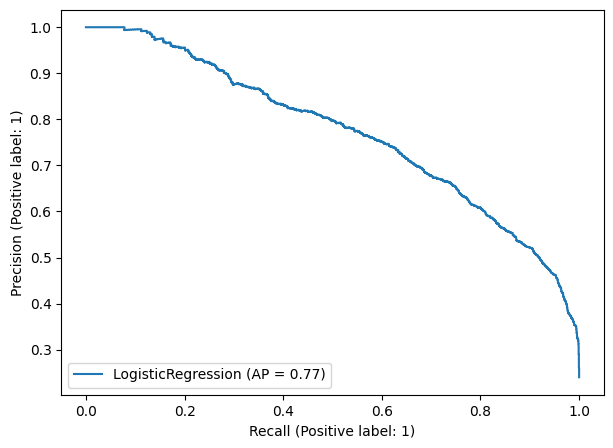

In [650]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
precision , recall, threshold = precision_recall_curve(y_test, probability_income_more_than_50k)
plt.style.use(['default'])
x = plot_precision_recall_curve(logistic, X_test_scaled, y_test)
x.figure_.set_figwidth(7)
x.figure_.set_figheight(5)

### Since the data is skewed, we consider f1 score to maximize and not accuracy.

In [20]:
y.value_counts()

0    33439
1    10518
Name: income_>50K, dtype: int64

In [651]:
f1score = (precision * recall * 2) / (precision + recall)
max_f1 = max(f1score)
max_index = f1score.tolist().index(max_f1)
threshold_f1 = threshold[max_index]
logistic_test_predictions = (probability_income_more_than_50k > threshold_f1).astype(np.int)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logistic_test_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, logistic_test_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logistic_test_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, logistic_test_predictions)))

Accuracy: 0.85
Precision: 0.66
Recall: 0.74
F1-score: 0.70


# KNN

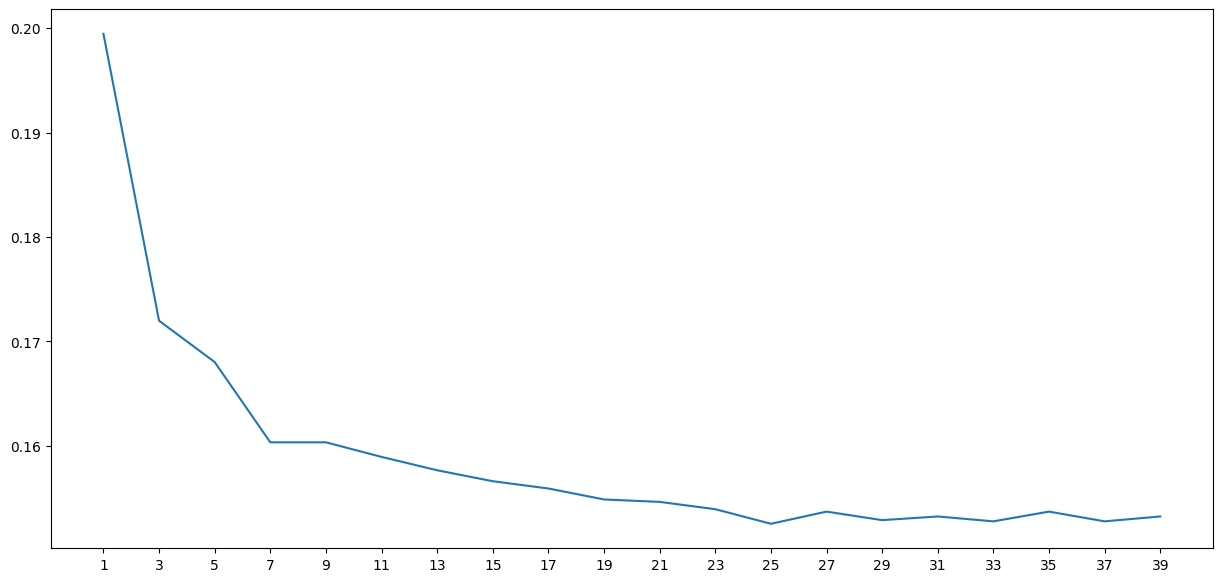

In [653]:
potential_k = np.arange(1, 40, 2)
knn_test_error = []
for k in potential_k:
    knn = KNN(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_predictions = knn.predict(X_test_scaled)
    knn_test_error.append(1 - accuracy_score(y_test, knn_predictions))

fig, _ = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
sns.lineplot(potential_k, knn_test_error)
plt.xticks(potential_k)
plt.show()

In [654]:
knn = KNN(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
knn_predictions = knn.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, knn_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, knn_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, knn_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, knn_predictions)))

Accuracy: 0.84
Precision: 0.69
Recall: 0.60
F1-score: 0.64


# SVM

## Linear

In [656]:
svm_linear = train_svm('linear', c=[1])
svm_linear_predictions = svm_linear.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_linear_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_linear_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_linear_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_linear_predictions)))

Accuracy: 0.86
Precision: 0.76
Recall: 0.59
F1-score: 0.66


## RBF

In [657]:
svm_rbf = train_svm('rbf', c=[1])
svm_rbf_predictions = svm_rbf.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_rbf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_rbf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_rbf_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_rbf_predictions)))

Accuracy: 0.86
Precision: 0.79
Recall: 0.57
F1-score: 0.66


## Poly

In [658]:
svm_poly = train_svm('poly', c=[1], degree=2) #DEGREE = 2
svm_poly_predictions = svm_poly.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_poly_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_poly_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_poly_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_poly_predictions)))

Accuracy: 0.86
Precision: 0.78
Recall: 0.57
F1-score: 0.66


In [660]:
svm_poly = train_svm('poly', c=[1], degree=5) #DEGREE=5
svm_poly_predictions = svm_poly.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_poly_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_poly_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_poly_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_poly_predictions)))

Accuracy: 0.85
Precision: 0.80
Recall: 0.50
F1-score: 0.62


# Conclusion

<ul>
    <li>The dataset is skewed, therefore the evaluation was based on F1-score rather than accuracy.</li>
    <br>
    <li> Logistic Regression performed the best, better than KNN and SVM because we had the flexiablity to choose the threshold on which we classify the data points. </li>
    <br>
    <li>Performance of KNN was outperformed by Logistic Regression because the dataset has a very high dimentionality (Curse of dimentionality problem).</li>
    <br>
    

</ul>

# Heart Disease Dataset

In [2]:
heart_df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
heart_df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [670]:
heart_df['HeartDiseaseorAttack'].value_counts()

0.0    229787
1.0     23893
Name: HeartDiseaseorAttack, dtype: int64

In [3]:
X = heart_df.drop('HeartDiseaseorAttack', axis='columns')
Y = heart_df['HeartDiseaseorAttack']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression

In [693]:
logistic = LogisticRegression()
logistic.fit(X_train_scaled, y_train)
logistic_test_predictions = logistic.predict_proba(X_test_scaled)
logistic_train_predictions = logistic.predict(X_train_scaled)
probability_heart_disease = logistic_test_predictions[:, 1]

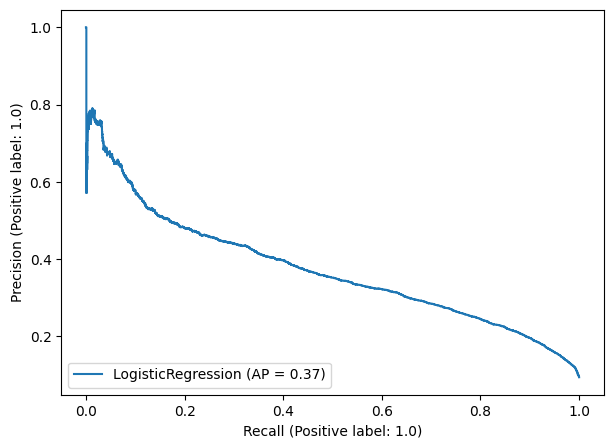

In [694]:
precision , recall, threshold = precision_recall_curve(y_test, probability_heart_disease)
plt.style.use(['default'])
x = plot_precision_recall_curve(logistic, X_test_scaled, y_test)
x.figure_.set_figwidth(7)
x.figure_.set_figheight(5)

### Note that here we prefer to choose a threshold that will maximize the recall. This is because we trying to detect a disease here so it would be better if we increase the true positive rate

In [696]:
logistic_test_predictions = (probability_heart_disease > 0.1).astype(np.int)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logistic_test_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, logistic_test_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logistic_test_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, logistic_test_predictions)))

Accuracy: 0.76
Precision: 0.25
Recall: 0.78
F1-score: 0.38


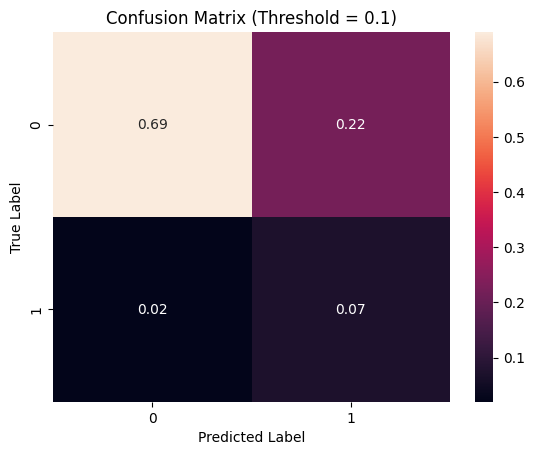

In [742]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, logistic_test_predictions) / len(X_test)
matrix = np.round_(matrix, 2)
s = sns.heatmap(matrix, annot=True)
s.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Matrix (Threshold = {})'.format(0.1))
plt.show()

# KNN

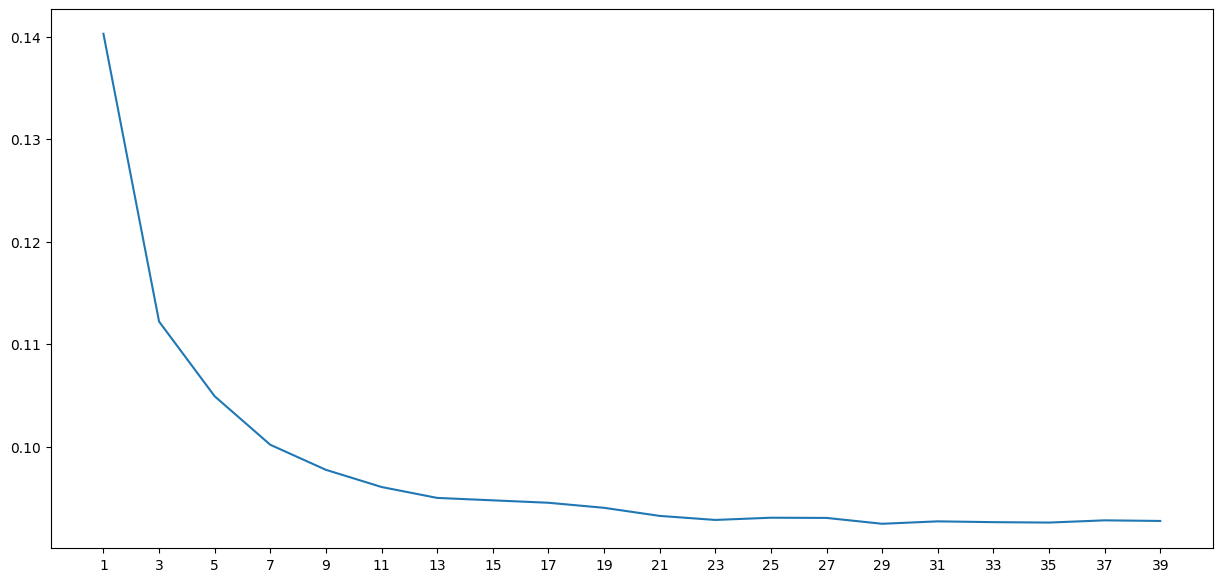

In [729]:
potential_k = np.arange(1, 40, 2)
knn_test_error = []
for k in potential_k:
    knn = KNN(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_predictions = knn.predict(X_test_scaled)
    knn_test_error.append(1 - accuracy_score(y_test, knn_predictions))

fig, _ = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
sns.lineplot(potential_k, knn_test_error)
plt.xticks(potential_k)
plt.show()

### Using Elbow method, we choose k=9

In [730]:
knn = KNN(n_neighbors=9)
knn.fit(X_train_scaled, y_train)
knn_predictions = knn.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, knn_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, knn_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, knn_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, knn_predictions)))

Accuracy: 0.90
Precision: 0.44
Recall: 0.13
F1-score: 0.20


# SVM

## Linear

In [743]:
svm_linear = train_svm('linear', c=[1])
svm_linear_predictions = svm_linear.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_linear_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_linear_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_linear_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_linear_predictions)))

Accuracy: 0.91
Precision: 0.00
Recall: 0.00
F1-score: 0.00


## RBF


In [744]:
svm_rbf = train_svm('rbf', c=[1])
svm_rbf_predictions = svm_rbf.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_rbf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_rbf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_rbf_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_rbf_predictions)))

Accuracy: 0.91
Precision: 0.64
Recall: 0.06
F1-score: 0.10


## Poly

In [6]:
svm_poly = train_svm('poly', c=[1], degree=2)
svm_poly_predictions = svm_poly.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_poly_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_poly_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_poly_predictions)))
print('F1-score: {:.2f}'.format(f1_score(y_test, svm_poly_predictions)))

Accuracy: 0.91
Precision: 0.60
Recall: 0.06
F1-score: 0.11


# Conclusion
<li>Note that here we prefer to choose a threshold that will maximize the recall. This is because we trying to detect a disease here so it would be better if we increase the true positive rate</li>
<li>SVM (with all kernels) had very good accuracy values but very low recall values.</li>
<li>KNN had relatively low recall value with higher F1 Score. Its overall performance is not good. This could be related with the cures of dimensionality</li>
<li>In logistic regression, again, we had the best recall values. This is because we had the flexibility to make use of the ROC curve that could help us choosing the best recall value with an acceptable F1 score and precision values</li>